# Libraries

In [1]:
import os
import datetime
from math import sqrt
import itertools

from IPython.display import SVG

# visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams.update({'figure.figsize': (15, 8), 'figure.dpi': 120})
plt.style.use('fivethirtyeight')

# keras model
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

import keras.backend as K

# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# tuning


# generalization
from tensorflow.keras.layers import Dropout

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Fetching

In [2]:
# define csv path
datapath = '../data/interim/household_unique/household_power_consumption_interim.csv'

In [3]:
# import / read dateset file
ts_house = pd.read_csv(datapath, low_memory=False)

# Data Scrubbing

In [4]:
# renaming columns for better readability
ts_house.columns = ts_house.columns.str.lower()

In [5]:
ts_house.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [17]:
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34589 entries, 0 to 34588
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               34589 non-null  object 
 1   Global_active_power    34589 non-null  float64
 2   Global_reactive_power  34589 non-null  float64
 3   Voltage                34589 non-null  float64
 4   Global_intensity       34589 non-null  float64
 5   Sub_metering_1         34589 non-null  float64
 6   Sub_metering_2         34589 non-null  float64
 7   Sub_metering_3         34589 non-null  float64
dtypes: float64(7), object(1)
memory usage: 2.1+ MB


In [18]:
ts_house.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,64.674459,7.329660,14268.938222,274.178918,66.470121,76.932869,382.640926
std,53.995513,4.066808,1608.365811,226.097083,211.089850,250.148948,440.306805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.218000,4.618000,14344.730000,89.400000,0.000000,0.000000,38.000000
50%,46.948000,6.364000,14455.770000,200.400000,0.000000,19.000000,99.000000
75%,94.206000,8.920000,14560.290000,393.800000,0.000000,39.000000,837.000000
max,393.632000,46.460000,15114.120000,1703.000000,2902.000000,2786.000000,1293.000000


# Data cleaning

## Missing values

In [19]:
ts_house.isnull().sum()

datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Duplicates

In [20]:
ts_house.duplicated().value_counts()

False    34589
dtype: int64

---------------

# Model Building

## Data selection

In [12]:
# split time series train/forecast sets
ts_train = ts_house[:2009-11]
ts_forecast = ts_house[2009-11:]

In [13]:
# split time series into train/test sets
X_train = ts_train.iloc[:, 1:].values
y_train = ts_train['global_active_power'].values

X_test = ts_forecast.iloc[:, 1:].values
y_test = ts_forecast['global_active_power'].values

Keras provides the TimeseriesGenerator that can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.

![image-ts_generator](https://machinelearningmastery.com/wp-content/uploads/2021/09/rnnCode2-1024x543.png)

## Preprocessing

### Scaling

In [14]:
# define standardscaler scaling method
scaler = StandardScaler()

In [15]:
# normalisation
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Data splitting

In [16]:
# split train/test sets
time_steps = 10
stride = 2
batch_size = 64

## train split set
ts_train = TimeseriesGenerator(X_train, y_train,
                           length=time_steps,
                           stride=stride,
                           batch_size=batch_size
                           )

X_train = ts_train[0][0]
y_train = ts_train[0][1]

## test split set
ts_test = TimeseriesGenerator(X_test, y_test,
                           length=time_steps,
                           stride=stride,
                           batch_size=64
                           )

X_test = ts_test[0][0]
y_test = ts_test[0][1]

------------------------------------

## Baseline model

## Model Instantiation

In [17]:
# define rmse custome function
def root_mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [30]:
def rnn(X_train, y_train, X_test, y_test, time_steps, epoch, batch, verbose, dropout):
    model = Sequential()
    model.add(SimpleRNN(100, activation='sigmoid', recurrent_dropout=dropout, input_shape=(batch_size, time_steps, X_train.shape[1])))
    model.add(Dense(100, activation='sigmoid', input_shape=(12, 7)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss="mse", metrics=root_mean_pred)
    model.fit(X_train, y_train,
                batch_size=batch,
                epochs= epoch,
                verbose=verbose,
                validation_data=(X_test, y_test))
    return model

In [32]:
# model instantiation
epoch = 2000
batch = 64
verbose = 2
dropout = 0.2
time_steps = 10

base_model = rnn(X_train, y_train, X_test, y_test, time_steps, epoch, batch, verbose, dropout)

ValueError: Input 0 of layer "simple_rnn_6" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 64, 10, 10)

### Performance

dict_keys(['loss', 'auc_3', 'recall_2', 'val_loss', 'val_auc_3', 'val_recall_2'])


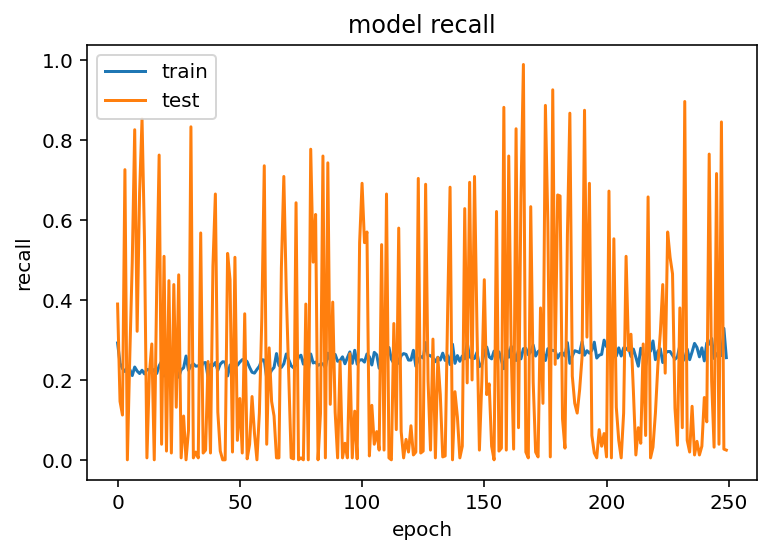

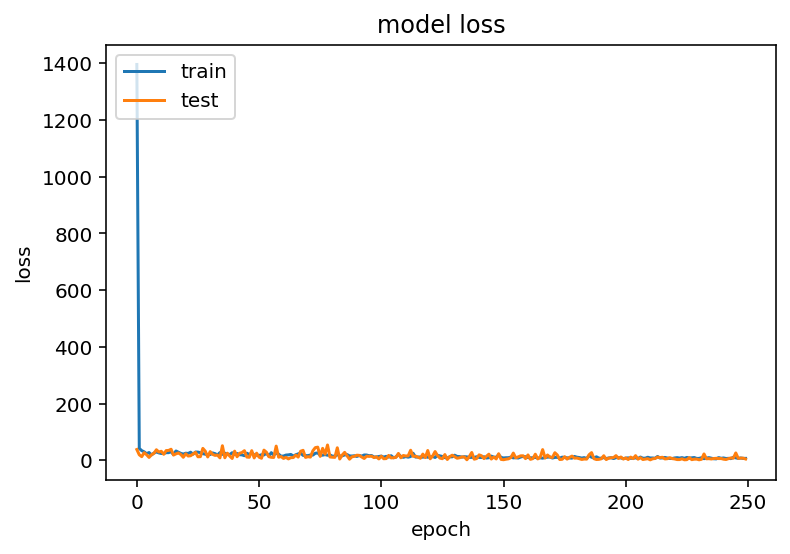

In [86]:
def plot_validate(model, loss_acc):
    '''Plot model accuracy or loss for both train and test validation per epoch
    model = fitted model
    loss_acc = input 'loss' or 'acc' to plot respective graph
    '''
    history = model.history.history

    if loss_acc == 'loss':
        axis_title = 'loss'
        title = 'Loss'
        epoch = len(history['loss'])
    elif loss_acc == 'acc':
        axis_title = 'acc'
        title = 'Accuracy'
        epoch = len(history['loss'])

    plt.figure(figsize=(15,4))
    plt.plot(history[axis_title])
    plt.plot(history['val_' + axis_title])
    plt.title('Model ' + title)
    plt.ylabel(title)
    plt.xlabel('Epoch')

    plt.grid(b=True, which='major')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', alpha=0.2)

    plt.legend(['Train', 'Test'])
    plt.show()


In [93]:
# plot confusion matrix
base_y_pred = base_model.predict(X_train, X_test)
print(confusion_matrix(y_test, base_y_pred))

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# ML Tuning

-------------------------------